In [1]:
# Install openpyxl if not installed
!pip install openpyxl --quiet

# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [16]:

# Load the Excel file using the correct sheet name
file_path = "/content/sample_data/Data_Airline_to_Py.xlsx"
df = pd.read_excel(file_path, sheet_name="Demandeq")

# Clean column names
df.columns = df.columns.str.strip()

# Convert 'Date' column to datetime
df['DateYM'] = pd.to_datetime(df['DateYM'])

# Set 'Date' as the index
df.set_index('DateYM', inplace=True)

# Display first few rows
df.head()


,Rpks,GDP,Yield,Dumy Vacations
DateYM,,,,
2015-01-01,13774656,1911198,0.111949,0
2015-02-01,12918782,1909731,0.114012,0
2015-03-01,14960327,1907789,0.113736,1
2015-04-01,13548366,1906000,0.111598,0
2015-05-01,13642565,1902034,0.112339,0


In [3]:
# Define the dependent and independent variables
X = df[['GDP', 'Yield', 'Dumy Vacations']]
y = df['Rpks']

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rpks   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     38.97
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           1.29e-17
Time:                        03:07:18   Log-Likelihood:                -2056.0
No. Observations:                 123   AIC:                             4120.
Df Residuals:                     119   BIC:                             4131.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.571e+06   6.85e+06      0.

In [4]:
# Apply logarithmic transformation
df_log = df[['Rpks', 'GDP', 'Yield', 'Dumy Vacations']].copy()
df_log['log_Rpks'] = np.log(df_log['Rpks'])
df_log['log_GDP'] = np.log(df_log['GDP'])
df_log['log_Yield'] = np.log(df_log['Yield'])

# Define independent and dependent variables for log model
X_log = df_log[['log_GDP', 'log_Yield', 'Dumy Vacations']]
X_log = sm.add_constant(X_log)
y_log = df_log['log_Rpks']

# Run the logged regression
model_log = sm.OLS(y_log, X_log).fit()

# Display the logged regression summary
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:               log_Rpks   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     239.2
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           3.29e-50
Time:                        03:07:21   Log-Likelihood:                -41.759
No. Observations:                 123   AIC:                             91.52
Df Residuals:                     119   BIC:                             102.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -43.2023      7.415     -5.

In [5]:
# 1. Durbin-Watson test for autocorrelation
dw_stat = durbin_watson(model_log.resid)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_log.columns
vif_data['VIF'] = [variance_inflation_factor(X_log.values, i) for i in range(X_log.shape[1])]

# Round VIF values to 2 decimals
vif_data['VIF'] = vif_data['VIF'].round(2)

# Optional: remove 'const' row from VIF table
vif_data = vif_data[vif_data['feature'] != 'const'].reset_index(drop=True)

# Display results
print(f"Durbin-Watson Statistic: {round(dw_stat, 2)}")
vif_data


Durbin-Watson Statistic: 0.55


,feature,VIF
0,log_GDP,1.0
1,log_Yield,1.0
2,Dumy Vacations,1.0


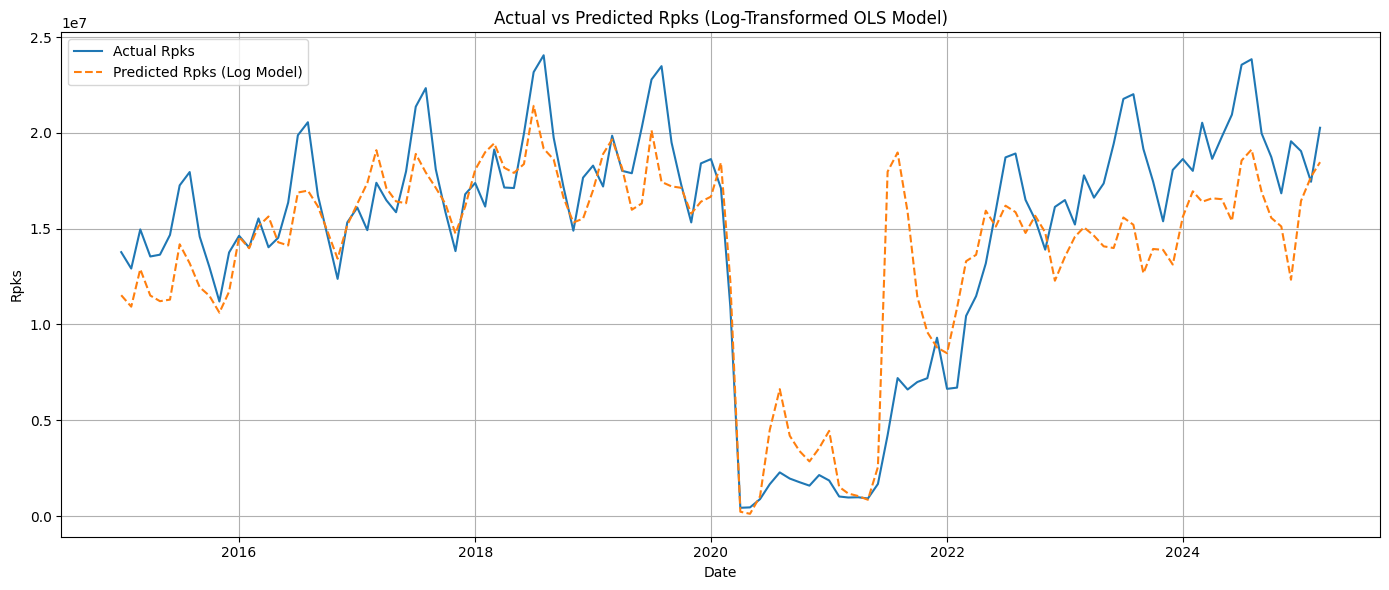

In [22]:
# Make predictions in log scale and convert to original scale
df['Predicted_log_Rpks'] = model_log.predict(X_log)
df['Predicted_Rpks'] = np.exp(df['Predicted_log_Rpks'])


# Plot actual vs predicted RPKs with date on x-axis
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Rpks'], label='Actual Rpks')
plt.plot(df.index, df['Predicted_Rpks'], label='Predicted Rpks (Log Model)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Rpks')
plt.title('Actual vs Predicted Rpks (Log-Transformed OLS Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
